## Assessing Imputation Methods

Assessing the effectiveness of imputation methods is essential, using both direct and indirect evaluations to gauge the accuracy of the imputed data. Below, we outline our method for evaluating imputation performance.

We perform a direct comparison between the imputed datasets and the original datasets by calculating the root mean square error (RMSE), providing a numerical metric of the disparity between imputed and true values. Furthermore, we evaluate the statistical robustness of the imputed datasets by examining the Log (P-value) in comparison to the original datasets.

To understand the effect of imputation on downstream analyses, we compare the results of a supervised machine learning model applied to both the imputed and original datasets using AUC values. This thorough assessment ensures that the imputed datasets preserve the original data's integrity and usability. For cross-comparison, we establish adjusted parameters to account for the standard deviation observed across multiple imputations and different scenarios of the simulated datasets, as shown below.

$$ \mu_{adj} = \mu_{avg} \pm 0.5 \mu_{std}, \mu \in \{NRMSD, \log(P\text{-value}), AUC\} $$


In [13]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import copy
import matplotlib
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import seaborn as sns
from scipy.stats import norm

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

#Direct assesment

## Direct Assessment of Imputation Methods

To perform a direct assessment, we compute the normalized root mean square deviation (NRMSD) as described in Equation (2). In this equation, \(N_i\) denotes the number of imputed values in the dataset for each missing data scenario.

$$ \text{NRMSD} = \sqrt{\frac{\sum_{i=1}^{N_i} ( \text{imputed} - \text{actual} )^2}{N_i (\text{max} - \text{min})^2}} $$

Direct assessment offers a straightforward way to compare the actual values with the imputed values, providing a clear quantitative measure of accuracy. However, this method does not evaluate the overall structure of the imputed data for post-imputation analysis, such as its ability to replicate the original data's statistical behavior or how well the input features collectively predict an outcome.




In [14]:
class AssessmentMetrics:
    def nrmsd(self, original, imputed, mask, columns):
        mean = np.mean(original[columns].values)
        min_max = np.max(original[columns].values)-np.min(original[columns].values)
        rmsd = mean_squared_error(original[columns].values, imputed[columns].values)/min_max
        return rmsd


In [17]:
#Reading the imputed data

num_folders=3 #The numebr of datasets you like to include for imputation of each missingness type

methods = ['AE', 'VAE', 'II (BR)', 'II (KNN)', 'II (RF)','MICE (CART)', 'MICE (NORM)','MICE (NORM.BOOT)','MICE (PMM)','MICE (RF)']

missing_types = ['MAR', 'MNAR', 'MCAR']


#percentages = [int(re.search(pattern, file).group()) for file in missingness_files]
#x_length = percentages[-1] - percentages[0]



original_file_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Data_without_NANs/Original_dataset.csv' # path of the original file
input_imputed_base_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Imputed_datasets_CS/'
missingness_base_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Data_with_missingness_CS/'
output_dir = '/mnt/isilon/For_Miad/Data_imputation/Serology/RMSD_CEDARS/'


metrics = AssessmentMetrics()
metric = metrics.nrmsd

In [18]:
results_mean = pd.DataFrame()
results_std = pd.DataFrame()
columns = ['anca', 'cbir', 'ompc', 'iga.asca', 'igg.asca', 'i2']
for method in methods:
    for missing_type in missing_types:
        input_missingness_dirs = [f'{missingness_base_dir}Numerical_data_{missing_type}_{i+1}/data/' for i in range(num_folders)]
        input_masks_dirs=[f'{missingness_base_dir}Numerical_data_{missing_type}_{i+1}/missing_masks/' for i in range(num_folders)]
        input_imputed_dirs =[f'{input_imputed_base_dir}{method}_{missing_type}_{i+1}' for i in range(num_folders)]
        RMSDs_total = []
        for input_missingness_dir, input_masks_dir, input_imputed_dir in zip(input_missingness_dirs,input_masks_dirs ,input_imputed_dirs):
# Before: missingness_files = sorted(os.listdir(input_missingness_dir), key=lambda x: int(re.search(r'\d+', x).group()))
# After: filtering to include only .csv files
            missingness_files = [file for file in os.listdir(input_missingness_dir) if file.endswith('.csv')]
            missingness_files = sorted(missingness_files, key=lambda x: int(re.search(r'\d+', x).group()))
            percentages = [int(re.search(r'\d+', file).group()) for file in missingness_files]
            RMSDs = []

            for missing_file in missingness_files:
                original = pd.read_csv(original_file_dir)
                mask = pd.read_csv(os.path.join(input_masks_dir, missing_file))
                RMSDn = []
                for i in range(1, 6):
                    imputed_file = missing_file[:-4] + '_Imputed_' + method + '_' + str(i) + '.csv'
                    imputed = pd.read_csv(os.path.join(input_imputed_dir, imputed_file))
                    RMSDn.append(metric(original,imputed,mask,columns))
                RMSDs.append(RMSDn)

            RMSDs = np.array(RMSDs)
            RMSDs_total.append(np.mean(RMSDs, axis=1))

        RMSDs_total = np.array(RMSDs_total)
        RMSDs_mean = np.mean(RMSDs_total, axis=0)
        RMSDs_std = np.std(RMSDs_total, axis=0)

        results_mean[method + '_' + missing_type] = RMSDs_mean
        results_std[method + '_' + missing_type] = RMSDs_std

#Calculate the adjusted values
NRMSD_adjusted=results_mean+0.5*results_std


In [32]:
NRMSD_adjusted

,AE_MAR,AE_MNAR,AE_MCAR,VAE_MAR,VAE_MNAR,VAE_MCAR,II (BR)_MAR,II (BR)_MNAR,II (BR)_MCAR,II (KNN)_MAR,...,MICE (NORM)_MCAR,MICE (NORM.BOOT)_MAR,MICE (NORM.BOOT)_MNAR,MICE (NORM.BOOT)_MCAR,MICE (PMM)_MAR,MICE (PMM)_MNAR,MICE (PMM)_MCAR,MICE (RF)_MAR,MICE (RF)_MNAR,MICE (RF)_MCAR
0,0.114619,0.859688,0.111475,0.113600,0.752360,0.102530,0.097487,0.609851,0.079504,0.099117,...,0.158763,0.202144,0.660567,0.158775,0.229055,0.707593,0.160419,0.268505,0.727265,0.153654
1,0.193723,1.087843,0.218503,0.189463,0.982373,0.203069,0.162476,0.810202,0.157136,0.159600,...,0.322237,0.333818,0.927258,0.322412,0.300271,1.005206,0.321219,0.382173,1.009242,0.316966
2,0.235652,1.082121,0.327499,0.238940,0.993406,0.306150,0.254592,0.808575,0.239869,0.222227,...,0.489969,0.529517,0.988816,0.489141,0.441759,1.060009,0.488193,0.508246,1.060726,0.485712
3,0.324578,0.917860,0.440055,0.333460,0.852029,0.415139,0.285943,0.702903,0.334644,0.320879,...,0.672469,0.686294,0.962815,0.668520,0.649472,1.011857,0.653300,0.700845,1.015337,0.651586
4,0.345829,0.980284,0.556122,0.349405,0.933043,0.529165,0.296516,0.772047,0.433130,0.312384,...,0.857580,0.769019,1.114310,0.867887,0.564466,1.171245,0.846702,0.545185,1.180140,0.834526
5,0.493738,0.955668,0.677202,0.514778,0.910325,0.653711,0.464037,0.754871,0.544813,0.484176,...,1.058826,1.013867,1.196899,1.051846,1.027467,1.228569,1.053861,1.052777,1.251175,1.039374
6,0.536952,0.922992,0.787253,0.563873,0.890202,0.768605,0.555351,0.752458,0.646053,0.511076,...,1.248810,1.180769,1.304472,1.257848,0.956226,1.295519,1.232231,0.917136,1.314840,1.224454
7,0.605192,0.977302,0.904972,0.648070,0.955847,0.891629,0.642389,0.808345,0.763906,0.592904,...,1.469263,1.420267,1.481621,1.466838,1.125024,1.471564,1.451764,1.130014,1.473932,1.442992


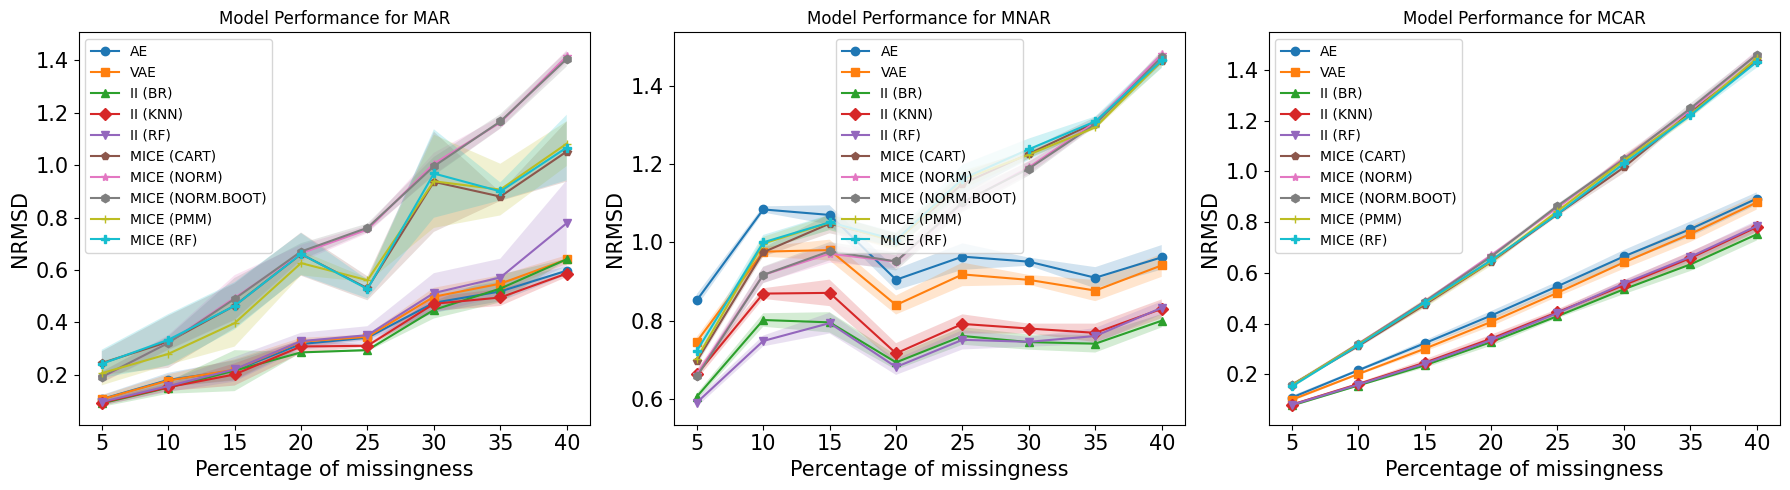

In [31]:
means_cedars=results_mean
stds_cedars=results_std

models = ['AE', 'VAE', 'II (BR)', 'II (KNN)', 'II (RF)','MICE (CART)', 'MICE (NORM)','MICE (NORM.BOOT)','MICE (PMM)','MICE (RF)']
missing_types = ['MAR', 'MNAR', 'MCAR']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h','+','P','>']  # Ensure you have as many markers as models
model_marker_map = dict(zip(models, markers))

x = range(5,45,5)
# Plot data for each missing type
for i, mt in enumerate(missing_types):
    ax = axs[i]
    for model in models:
        col = f'{model}_{mt}'
        #print(col)
        if col in means_cedars.columns and col in stds_cedars.columns:
            mean = means_cedars[col]
            std = stds_cedars[col]
            marker = model_marker_map[model]
            ax.plot(x, mean, label=model, marker=marker)
            ax.fill_between(x, mean - std, mean + std, alpha=0.2)

    ax.set_title(f'Model Performance for {mt}')
    ax.set_xlabel('Percentage of missingness',fontsize=15)
    ax.set_ylabel('NRMSD',fontsize=15)
    ax.legend()

plt.tight_layout()
plt.show()

#Indirect Assessment


While direct assessment emphasizes point-to-point accuracy, it does not consider the impact of imputation on the data's holistic properties. Therefore, it is crucial to conduct indirect assessments to obtain a comprehensive evaluation of the imputation's performance. Indirect assessments help ensure that the imputed data retains the integrity and predictive power of the original dataset, providing a more complete understanding of the imputation's effectiveness.



## Statistical Analysis of IBD Research

A significant portion of IBD research involves statistical analyses to explore the relationships between input features and IBD-related phenotypes. In this section, we present the outcomes of a univariate association analysis between each serologic feature and IBD phenotypes. We use adjusted -Log P-values obtained from logistic regression as our primary metric for comparing imputed datasets with the original datasets.

For each imputation scenario, we generate five imputed datasets and apply Rubin’s method to calculate the logistic regression coefficients and their standard deviations. Rubin's Rules ensure that both within-imputation and between-imputation variances are accounted for, resulting in precise and dependable combined estimates.

We present the association analysis results for three disease categories: CD vs. non-IBD, UC vs. non-IBD, and CD vs. UC.






In [1]:
##Define all the functions for statitical analysis

def rubins_rules(results_list):
    # Calculate combined coefficients and variances
    coefs = [result.params.iloc[1] for result in results_list]
    ses = [result.bse.iloc[1] for result in results_list]

    mean_coef = np.mean(coefs)
    within_var = np.mean([se**2 for se in ses])
    between_var = np.var(coefs, ddof=1)
    total_var = within_var + (1 + 1/len(results_list)) * between_var
    combined_se = np.sqrt(total_var)

    return mean_coef, combined_se, total_var


import scipy.stats as stats

def single_association_logistic_Rubin(imputed_datasets, input_columns_of_interest, output_column_of_interest, output_label):
    rows_list = []
    for marker in input_columns_of_interest:
        results = []
        for data_frame in imputed_datasets:
            y = data_frame[output_column_of_interest].astype(int)
            X = sm.add_constant(data_frame[[marker]])
            model = sm.Logit(y, X)
            result = model.fit(disp=0)
            results.append(result)

        # Apply Rubin's Rules here for each marker
        mean_coef, combined_se, _ = rubins_rules(results)

        # Calculate z-score using combined statistics
        z_score = mean_coef / combined_se
        p_value = 2 * stats.norm.sf(np.abs(z_score))  # Two-tailed test using survival function for numerical stability

        odds_ratio = np.exp(mean_coef)
        ci_lower = np.exp(mean_coef - 1.96 * combined_se)
        ci_upper = np.exp(mean_coef + 1.96 * combined_se)

        # Append results as scalars
        rows_list.append({
            'Marker': marker,
            'Output': output_label,
            'Coefficient': mean_coef,
            'Odds Ratio': odds_ratio,
            'SE': combined_se,
            'P-Value': p_value,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper
        })

    # Create DataFrame and sort
    summary_table = pd.DataFrame(rows_list)
    summary_table = summary_table.sort_values(by='P-Value')
    summary_table.reset_index(drop=True, inplace=True)
    return summary_table




def single_variate_association_logistic(data_frame, input_columns_of_interest, output_column_of_interest, output_label):
    results_list = []  # List to hold dictionary of results

    y = data_frame[output_column_of_interest].astype(int)  # Ensure y is integer

    for marker in input_columns_of_interest:
        X = sm.add_constant(data_frame[[marker]])  # Ensure X is numeric and add a constant
        model = sm.Logit(y, X)
        result = model.fit(disp=0)  # Suppress fit output

        # Collect results in a dictionary and append to the list
        results_list.append({
    'Marker': marker,
    'Output': output_label,
    'Coefficient': result.params.iloc[1],  # Use iloc[1] to access by position
    'Odds Ratio': np.exp(result.params.iloc[1]),  # Use iloc[1] to access by position
    'SE': result.bse.iloc[1],  # Use iloc[1] to access by position
    'P-Value': result.pvalues.iloc[1],  # Use iloc[1] to access by position
    '95% CI Lower': np.exp(result.conf_int().loc[marker, 0]),
    '95% CI Upper': np.exp(result.conf_int().loc[marker, 1])
        })

    # Create DataFrame from list of dictionaries
    summary_table = pd.DataFrame(results_list)

    # Sorting by P-Value
    summary_table = summary_table.sort_values(by='P-Value').reset_index(drop=True)

    return summary_table


def extract_percentage(filename):
    # This regex pattern finds one or more digits, preferring those followed by '%'
    match = re.search(r'(\d+)%?', filename)
    if match:
        return match.group(1)  # Return the first group of digits found
    return 'Unknown'  # Return a default or error value if no digits are found





def process_models(diagnosis_mapping,output_label,methods, missing_types, base_input_dir, base_input_missingness_dir,phenotype_path, original_data_path):
    columns = ['anca', 'cbir', 'ompc', 'iga.asca', 'igg.asca', 'i2']
    output_col = 'Current Diagnosis'
    original = pd.read_csv(original_data_path)
    original = original.rename(columns={'ID': 'Genetic ID'})
    phenotype = pd.read_csv(phenotype_path)
    original_phenotype_merged = pd.merge(original, phenotype[['Genetic ID', 'Current Diagnosis']], on='Genetic ID', how='inner')
    data = original_phenotype_merged[original_phenotype_merged['Current Diagnosis'].isin(diagnosis_mapping.keys())].copy()
    data.loc[:, 'Current Diagnosis'] = data['Current Diagnosis'].map(diagnosis_mapping).astype(int)

    output_column_of_interest = 'Current Diagnosis'

    #data,columns_normalzied=normalize(df=data,columns=columns)
    assoc_results=single_variate_association_logistic(data,columns,output_column_of_interest,output_label)


    all_results = []  # List to store all DataFrames for final concatenation

    # Append the original dataset results
    assoc_results['Method'] = 'Original'
    assoc_results['Missing Type'] = 'None'
    assoc_results['Percentage'] = 'None'
    all_results.append(assoc_results)

    for method in methods:
        for missing_type in missing_types:
            group = f'MICE ({method.upper()}) with {missing_type}'

            num_folders=3
            input_missingness_dirs = []
            input_masks_dirs = []
            input_imputed_dirs = []
            for i in range(num_folders):
                input_missingness_dirs.append(base_input_missingness_dir+'/Numerical_data_'+missing_type+f'_{i+1}/data/')
                input_masks_dirs.append(base_input_missingness_dir+'Numerical_data_'+missing_type+f'_{i+1}/missing_masks/')
                input_imputed_dirs.append(base_input_dir+method+'_'+missing_type+f'_{i+1}')


            for ind , (input_missingness_dir,input_masks_dir,input_imputed_dir) in enumerate(zip(input_missingness_dirs,input_masks_dirs,input_imputed_dirs)):
            # List and sort the CSV files
                missingness_files = [file for file in os.listdir(input_missingness_dir) if file.endswith('.csv')]

                missingness_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

                for index, missing_file in enumerate(missingness_files):
                    imputed_datasets=[]
                    for i in range(1, 6):
                        if method=='CP':
                           imputed_file = missing_file[:-4]+ '_'+ method  + '.csv'
                        else:
                           imputed_file = missing_file[:-4] + '_Imputed_' + method +  '_' + str(i) + '.csv'
                        imputed = pd.read_csv(os.path.join(input_imputed_dir, imputed_file))
                        imputed = imputed.rename(columns={'ID':'Genetic ID'})

                        imputed_phenotype_merged = pd.merge(imputed,phenotype[['Genetic ID','Current Diagnosis']],on='Genetic ID',how = 'inner')
                        data = imputed_phenotype_merged[imputed_phenotype_merged['Current Diagnosis'].isin(["Crohn's Disease","Ulcerative Colitis"])].copy()
                        data.loc[:, 'Current Diagnosis'] = data['Current Diagnosis'].map(diagnosis_mapping).astype(int)
                        #data,columns_normalzied=normalize(df=data,columns=columns)
                        imputed_datasets.append(data)
                    assoc_results=single_association_logistic_Rubin(imputed_datasets,columns,output_column_of_interest,output_label)
                    assoc_results['Method'] = method
                    assoc_results['Missing Type'] = missing_type
                    assoc_results['Percentage']=extract_percentage(missing_file)
                    all_results.append(assoc_results)
    final_results = pd.concat(all_results, ignore_index=True)
    return final_results


def plot_forest(df, coefficient_col, ci_lower_col, ci_upper_col, method_col ,marker, original_method_name=None,):
    matplotlib.rc('xtick', labelsize=12)
    matplotlib.rc('ytick', labelsize=12)
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(10, len(df) / 2))  # Dynamic size based on number of methods

    # Sort values for better visualization
    df_sorted = df.sort_values(by=coefficient_col, ascending=False)
    df_sorted = df_sorted.reset_index(drop=True)

    # Calculate error bars; ensure they are non-negative
    df_sorted['lower_error'] = (df_sorted[coefficient_col] - df_sorted[ci_lower_col]).abs()
    df_sorted['upper_error'] = (df_sorted[ci_upper_col] - df_sorted[coefficient_col]).abs()

    # Assign a unique color to each method using a color palette
    methods = df_sorted[method_col].unique()
    colors = sns.color_palette("husl", len(methods))
    color_dict = {method: colors[i] for i, method in enumerate(methods) if method != 'Original (None)'}

    # Error bars with different colors for original and imputed methods
    for i, row in df_sorted.iterrows():
        color = 'black' if row[method_col] == original_method_name else color_dict.get(row[method_col], 'gray')
        ax.errorbar(row[coefficient_col], i,
                    xerr=[[row['lower_error']], [row['upper_error']]],
                    fmt='o', color=color, label=row[method_col])

    # Handle the legend to avoid duplicates
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),fontsize=12)

    # Reference line for original coefficient
    x_0 = df[df[method_col] == original_method_name][coefficient_col].values[0]
    ax.axvline(x=x_0, color='red', linestyle='--')

    ax.set_xlabel('Log-odds ratio',fontsize=15)
    ax.set_yticks(range(len(df_sorted)))
    ax.set_yticklabels(df_sorted[method_col],fontsize=12)
    ax.set_title(f'Forest Plot of {marker}',fontsize=15)



    plt.tight_layout()
    return fig, ax  #




def perform_average_analysis(df):
    # Group by 'Marker', 'Missing Type', 'Method', and 'Percentage' to process for each scenario
    grouped = df.groupby(['Marker', 'Missing Type', 'Method','Percentage'])

    results = []

    for (marker, missing_type, method, percentage), group in grouped:
        # Calculate simple averages
        avg_coef = group['Coefficient'].mean()
        avg_se = group['SE'].mean()
        logpvalue_ave=(-np.log10(group['P-Value'])).mean()
        if method == 'Original':
           logpvalue_se=logpvalue_ave*0
        else:
          logpvalue_se=(-np.log10(group['P-Value'])).std()
        logpvalue_ave_adjusted = logpvalue_ave-0.5*logpvalue_se
        # Calculate z-score and p-value using averaged statistics
        z_score = avg_coef / avg_se
        p_value = 2 * norm.sf(np.abs(z_score))  # Two-tailed test

        # Calculate the odds ratio and 95% confidence intervals
        odds_ratio = np.exp(avg_coef)
        ci_lower = np.exp(avg_coef - 1.96 * avg_se)
        ci_upper = np.exp(avg_coef + 1.96 * avg_se)

        # Append results
        results.append({
            'Marker': marker,
            'Missing Type': missing_type,
            'Percentage':percentage,
            'Method': method,
            'Average Coefficient': avg_coef,
            'Average SE': avg_se,
            'P-Value': p_value,
            'Average Odds Ratio': odds_ratio,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper,
            '-Log P-Value': logpvalue_ave,
            '-Log P-Value SE': logpvalue_se,
            '-Log P-Value Adjusted': logpvalue_ave_adjusted
        })

    return pd.DataFrame(results)

In [4]:


methods = ['AE', 'VAE', 'II (BR)', 'II (KNN)', 'II (RF)','MICE (CART)', 'MICE (NORM)','MICE (NORM.BOOT)','MICE (PMM)','MICE (RF)']

missing_types = ['MAR', 'MNAR', 'MCAR']



base_input_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Imputed_datasets_CS/'#The iput directory for the imputed datasets
base_input_missingness_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Data_with_missingness_CS/'#The iput directory where the files with missingness reside
phenotype_path = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Phenotype_data_IU.csv'# path of the phenotpye file
original_file_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Data_without_NANs_CS/Original_dataset_IU.csv'# path of the original file
base_input_complete_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Complete_dataset_CS/'

#Adjust the output_label and diagnosis_mapping files based in association of interest
output_label='CD vs UC'
diagnosis_mapping = {"Crohn's Disease": 1, 'Ulcerative Colitis': 0}

statistics_imputed = process_models(diagnosis_mapping,output_label,methods, missing_types, base_input_dir, base_input_missingness_dir,phenotype_path, original_file_dir)
statistics_imputed.fillna('None',inplace=True)
methods=['CP']
statistics_complete = process_models(diagnosis_mapping,output_label,methods, missing_types,base_input_complete_dir, base_input_missingness_dir,phenotype_path, original_file_dir)
statistics_complete.fillna('None',inplace=True)

data_statistics=pd.concat([statistics_imputed,statistics_complete]).drop_duplicates()

In [5]:
data_statistics.head()

,Marker,Output,Coefficient,Odds Ratio,SE,P-Value,95% CI Lower,95% CI Upper,Method,Missing Type,Percentage
0,igg.asca,CD vs UC,0.046967,1.048087,0.002649,2.406720e-70,1.042660,1.053542,Original,None,None
1,anca,CD vs UC,-0.018809,0.981367,0.001143,7.283680e-61,0.979172,0.983568,Original,None,None
2,iga.asca,CD vs UC,0.088078,1.092073,0.005917,4.115586e-50,1.079481,1.104812,Original,None,None
3,cbir,CD vs UC,0.030960,1.031445,0.002166,2.385383e-46,1.027075,1.035833,Original,None,None
4,ompc,CD vs UC,0.033048,1.033600,0.003134,5.357708e-26,1.027270,1.039968,Original,None,None


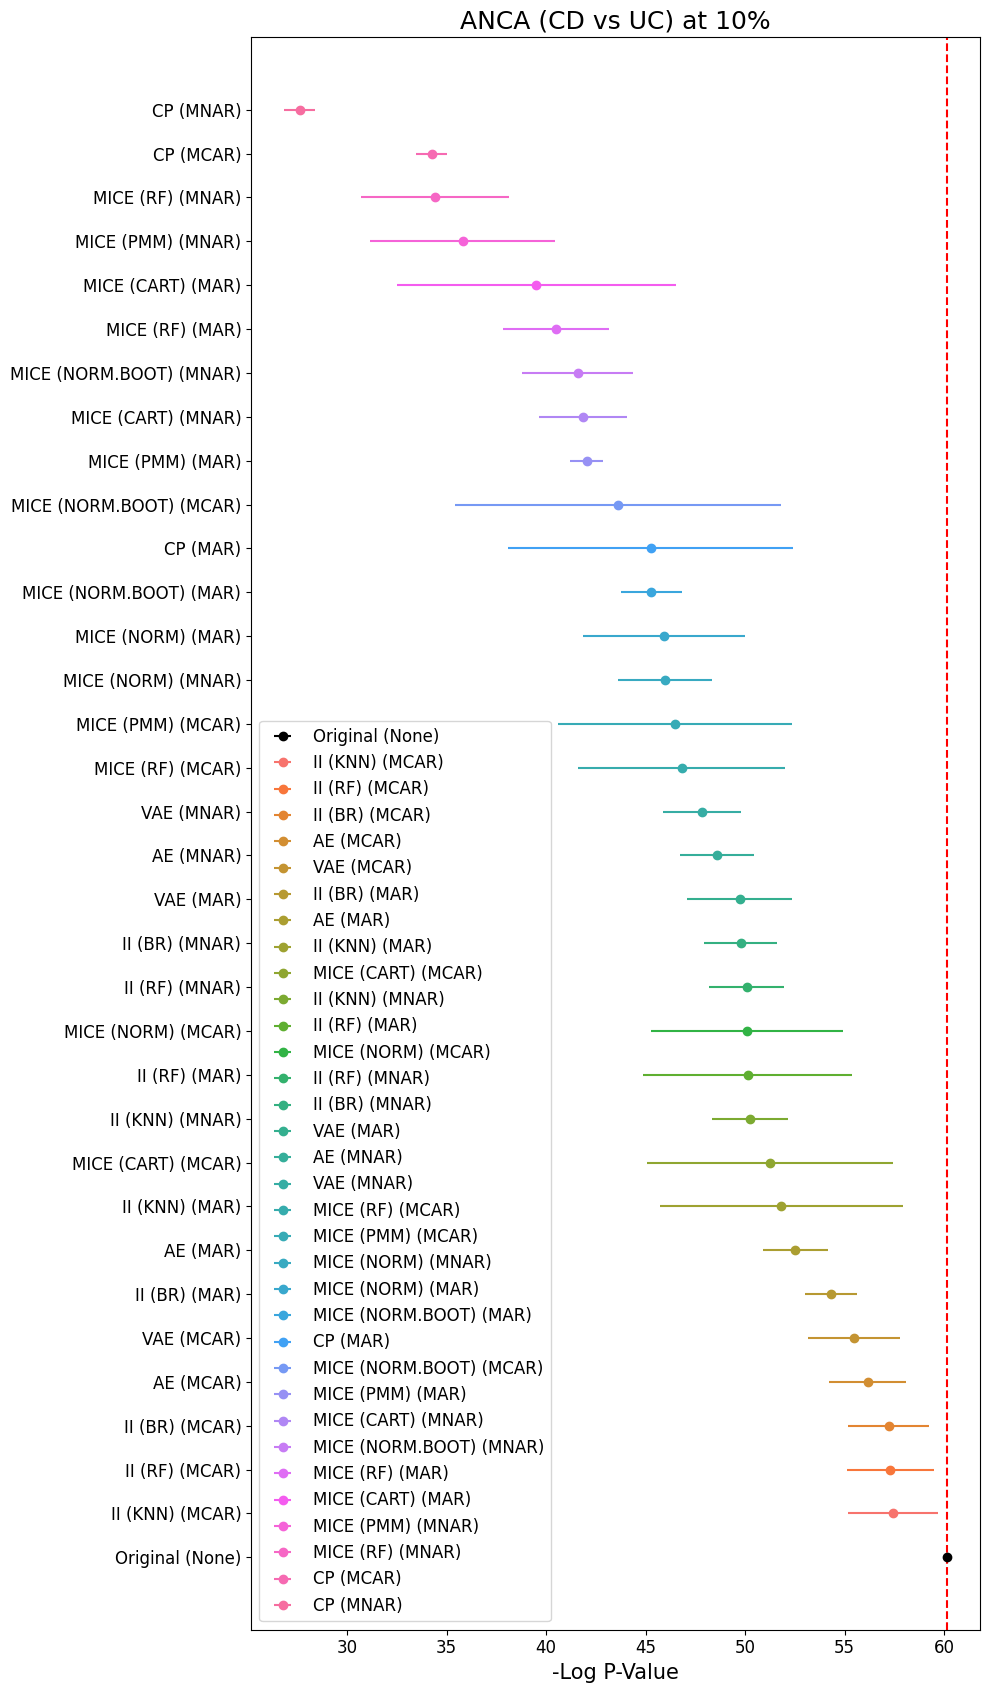

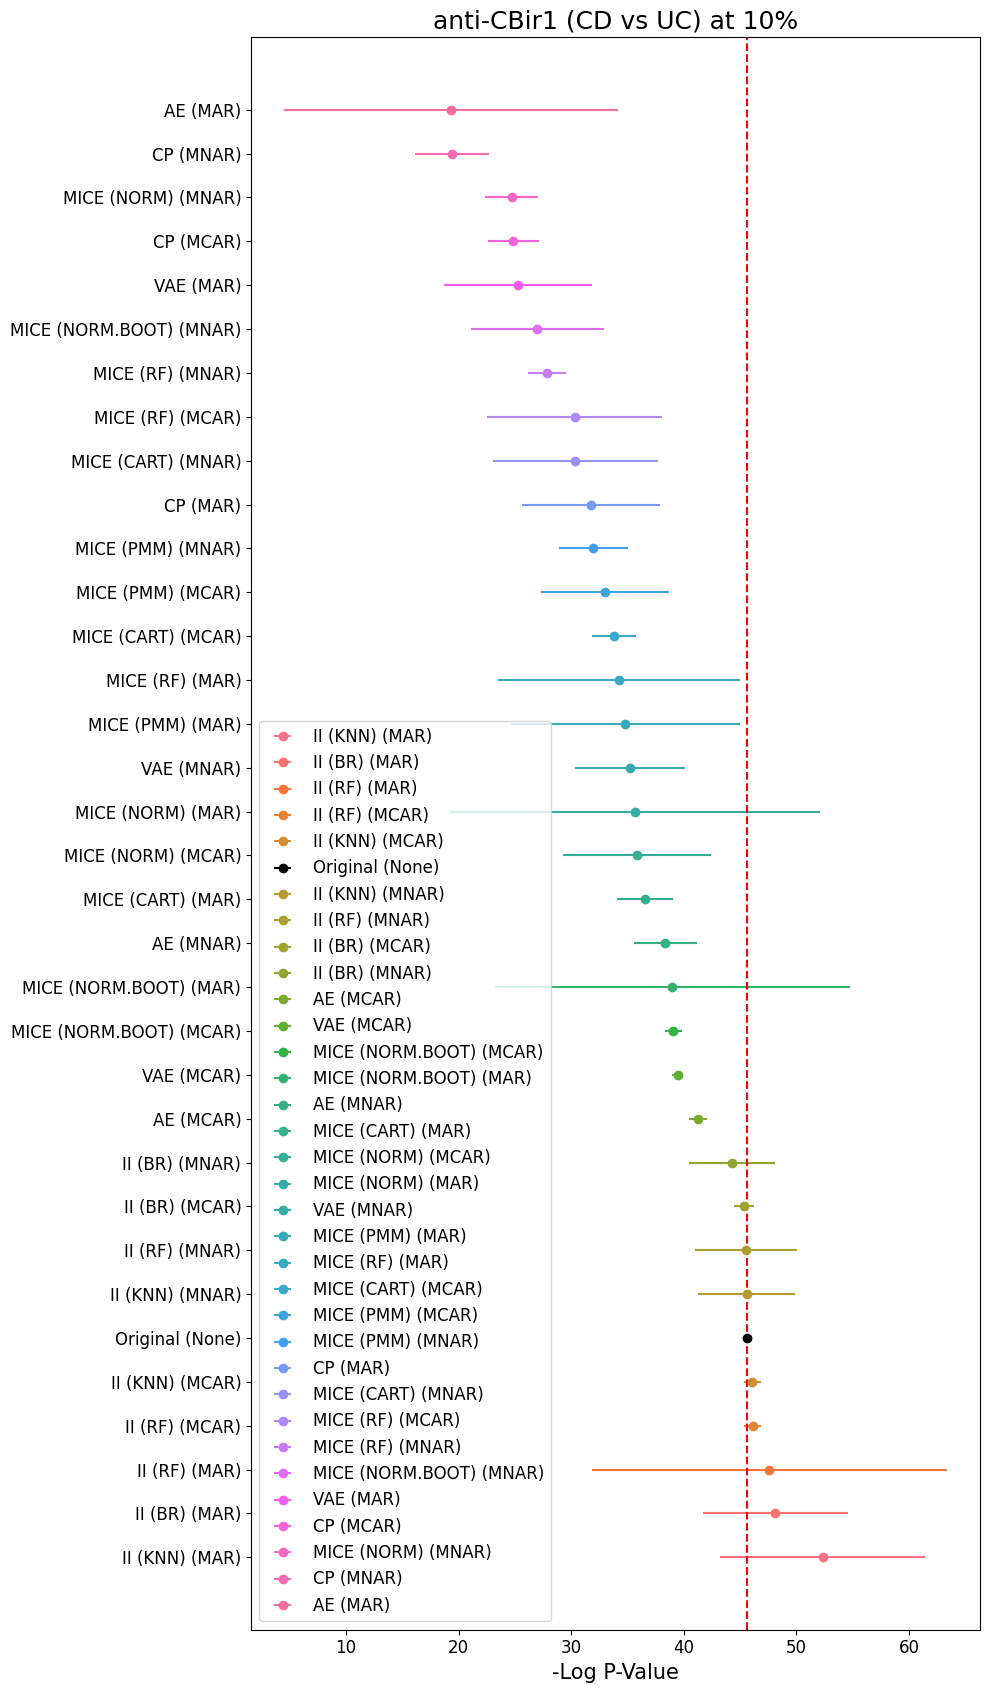

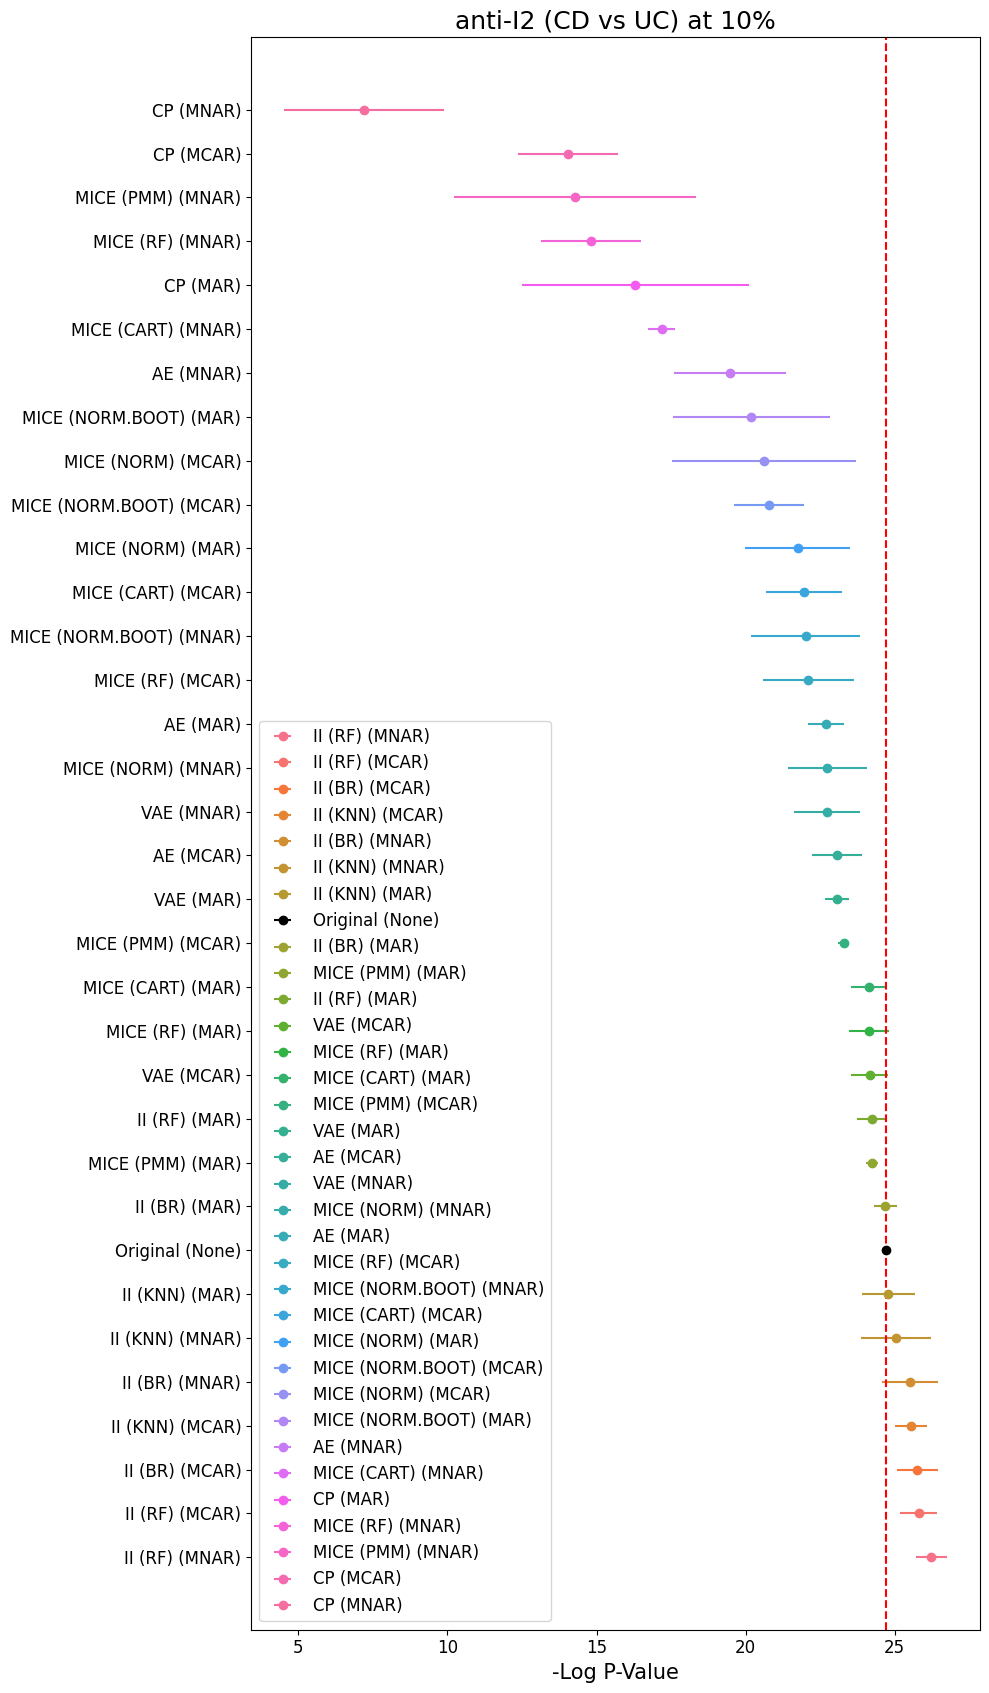

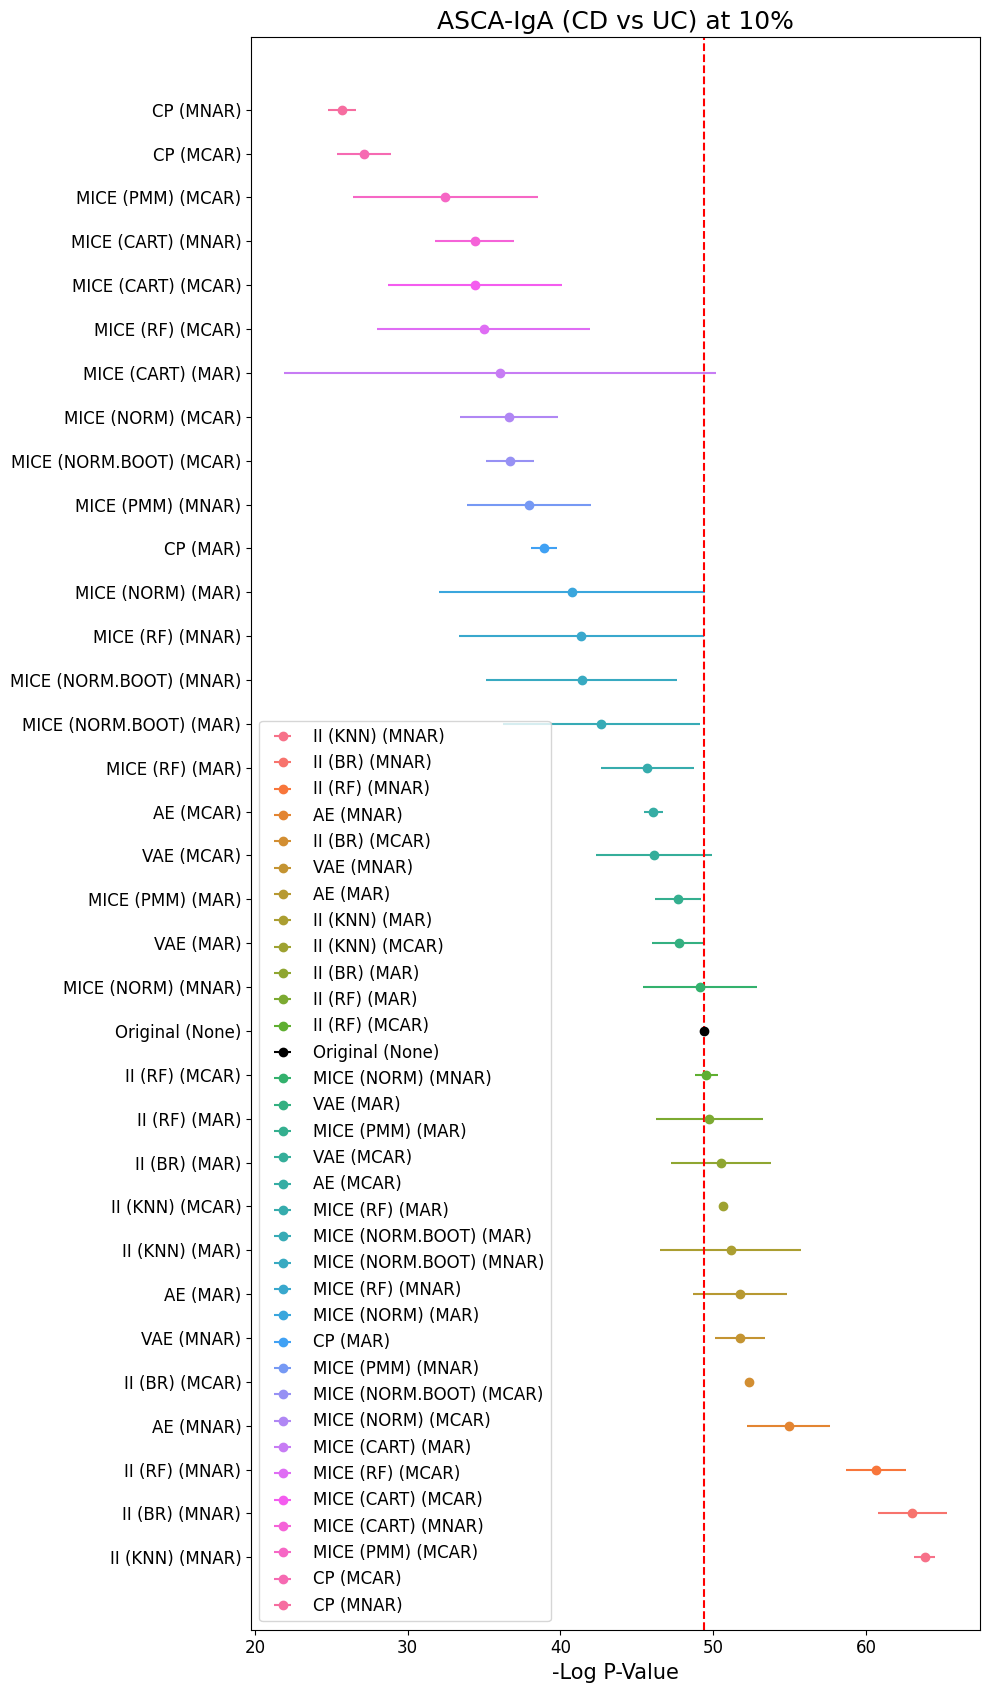

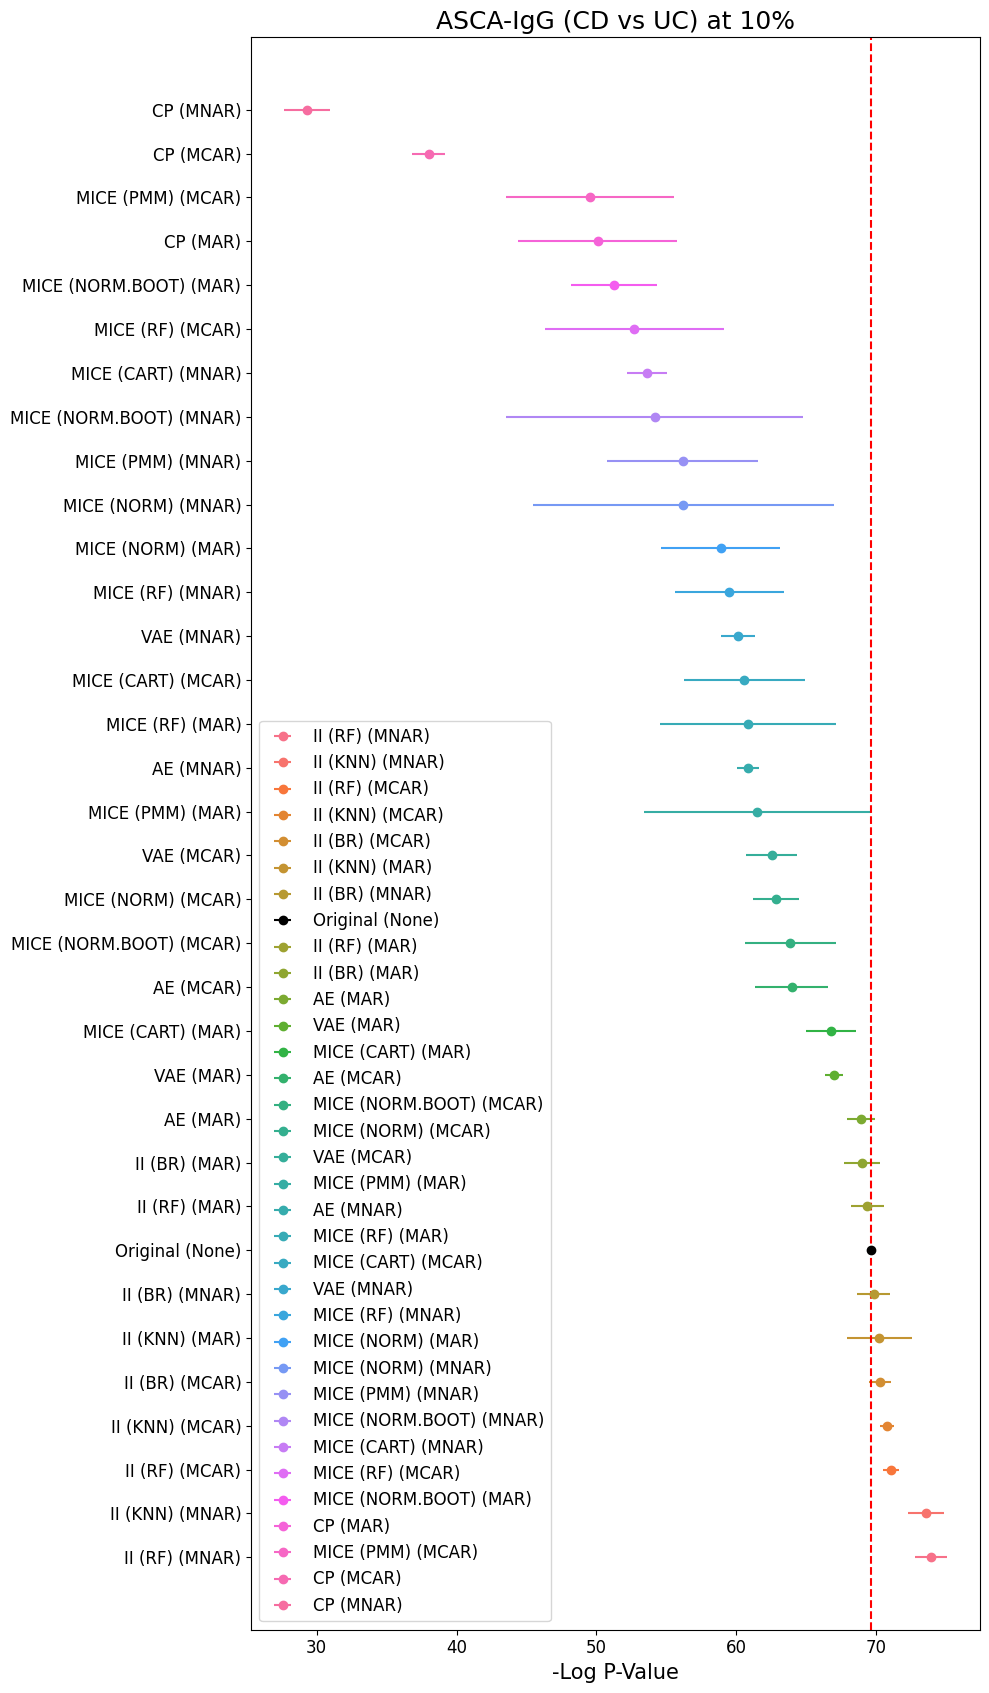

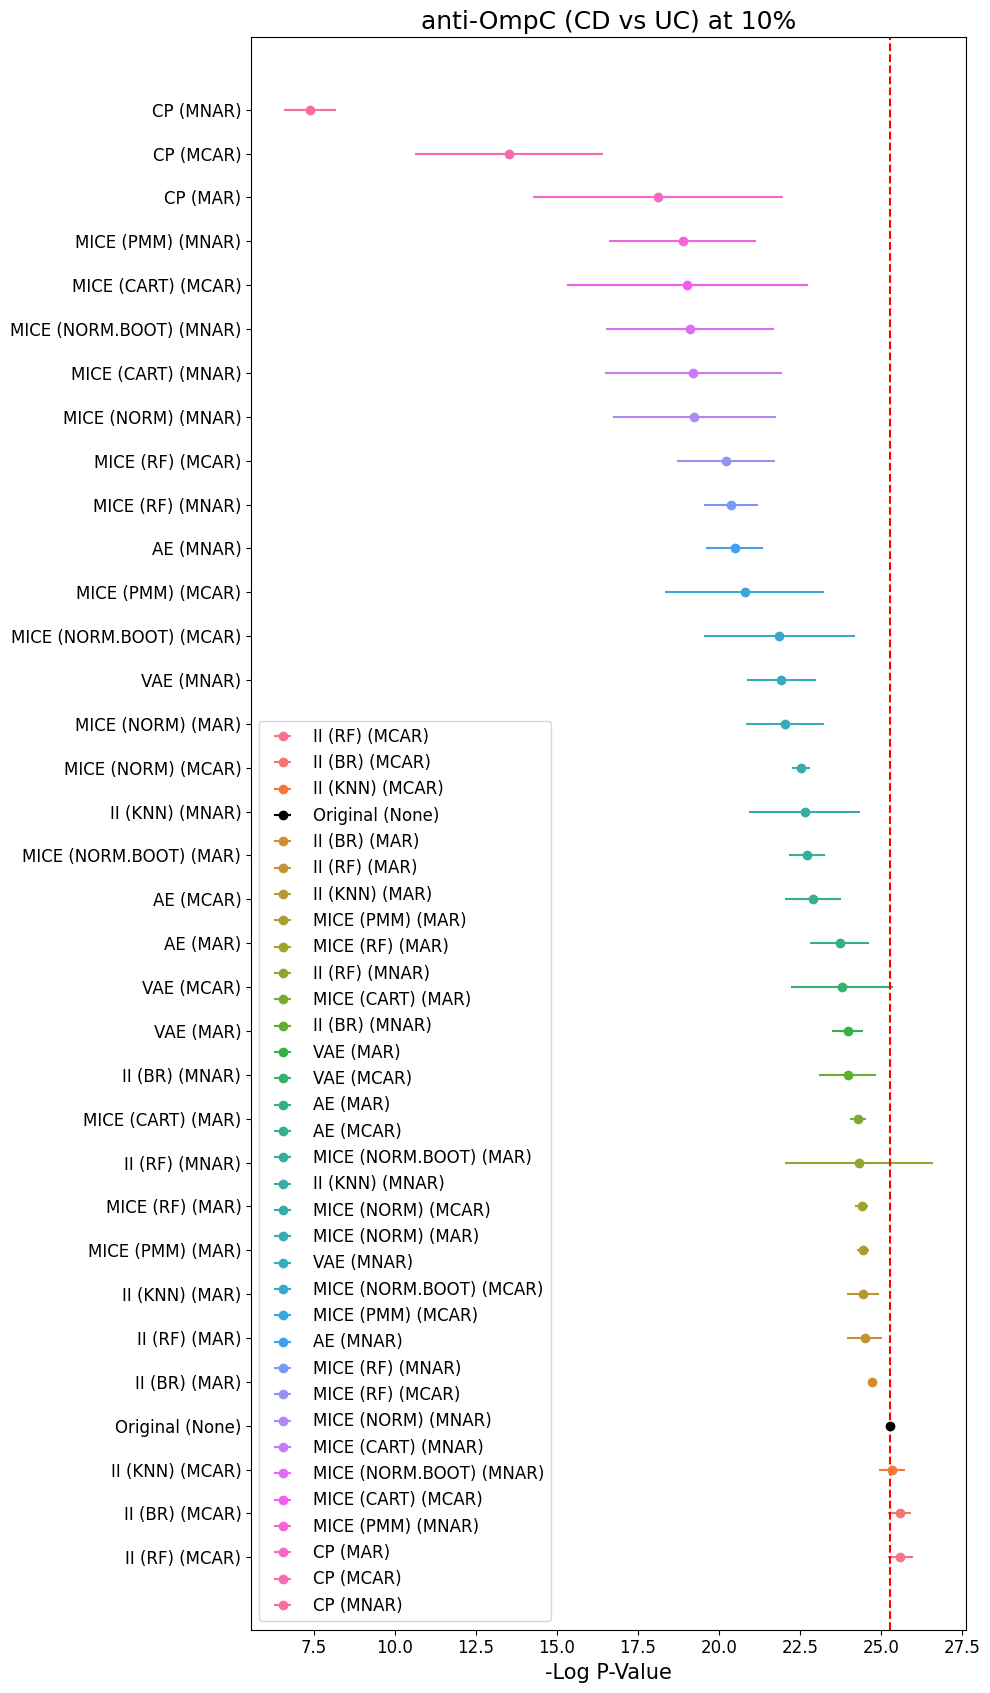

In [6]:
df = data_statistics.copy()
meta_stats=perform_average_analysis(df)


markers_dict={'anca':'ANCA','cbir':'anti-CBir1', 'ompc':'anti-OmpC', 'iga.asca':'ASCA-IgA', 'igg.asca':'ASCA-IgG', 'i2':'anti-I2'}

#meta_dfff = meta_stats.copy()
percentage='10'
meta_df = meta_stats[meta_stats['Percentage'].isin([percentage,'None'])].reset_index(drop=True).copy()

meta_df['Marker'] = meta_df['Marker'].map(markers_dict)
meta_df["95% coeff Upper"] = meta_df["-Log P-Value"] + meta_df["-Log P-Value SE"]
meta_df["95% coeff Lower"] = meta_df["-Log P-Value"] - meta_df["-Log P-Value SE"]



tip='CD vs UC'

for marker in meta_df['Marker'].unique():
    meta_marker_df = meta_df[meta_df['Marker']==marker].reset_index(drop=True)
    meta_marker_df['Method_Missingness'] = meta_marker_df['Method'] + " (" + meta_marker_df['Missing Type'] + ")"

    # Plot for Coefficient
    fig, ax = plot_forest(meta_marker_df, '-Log P-Value', "95% coeff Lower", "95% coeff Upper", 'Method_Missingness',marker, original_method_name='Original (None)')
    ax.set_title(f'{marker} ({tip}) at {percentage}%',fontsize=18)
    ax.set_xlabel('-Log P-Value',fontsize=15)



# Machine Learning Analysis



With the advent of machine learning techniques, there is growing interest in applying these advanced methods to various IBD-related applications. In this study, we investigate three distinct classifications for differentiating between IBD subgroups: CD vs. non-IBD, UC vs. non-IBD, and CD vs. UC, utilizing machine learning methods in a manner similar to our statistical approach.

We employ a gradient boost classifier combined with 5-fold cross-validation to calculate the Area Under the Curve (AUC) values for each classification scenario. This approach allows us to assess the performance of machine learning models in distinguishing between different IBD subgroups.


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
import re
import os

def evaluate_model(data, input_col, output_col):
    X = data[input_col]
    y = data[output_col].astype(int)

    # Initialize the classifier
    clf = GradientBoostingClassifier()

    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=5)
    mean_fpr = np.linspace(0, 1, 100)  # 100 evenly spaced points
    tprs = []
    aucs = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        clf.fit(X_train, y_train)

        # Make predictions and calculate probabilities
        probas_ = clf.predict_proba(X_test)[:, 1]

        # Compute ROC curve and area under the curve
        fpr, tpr, _ = roc_curve(y_test, probas_)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Interpolate the TPR based on defined mean FPR
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  # Ensuring the TPR starts at 0
        tprs.append(interp_tpr)

    # Calculate the mean TPR and AUC across folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Ensuring the TPR ends at 1
    mean_auc = np.mean(aucs)

    return {
        'Mean FPR': mean_fpr,
        'Mean TPR': mean_tpr,
        'Mean AUC': mean_auc
    }

def ML_analysis(diagnosis_mapping, methods, missing_types, base_input_dir, base_input_missingness_dir, phenotype_path, original_data_path):
    columns = ['anca', 'cbir', 'ompc', 'iga.asca', 'igg.asca', 'i2']
    output_col = 'Current Diagnosis'
    original = pd.read_csv(original_data_path)
    original = original.rename(columns={'ID': 'Genetic ID'})
    phenotype = pd.read_csv(phenotype_path)
    original_phenotype_merged = pd.merge(original, phenotype[['Genetic ID', 'Current Diagnosis']], on='Genetic ID', how='inner')
    data = original_phenotype_merged[original_phenotype_merged['Current Diagnosis'].isin(diagnosis_mapping.keys())].copy()
    data.loc[:, 'Current Diagnosis'] = data['Current Diagnosis'].map(diagnosis_mapping).astype(int)  # Use loc to avoid SettingWithCopyWarning
    auc_original = evaluate_model(data, columns, output_col)["Mean AUC"]

    results_df_mean = pd.DataFrame(columns=['Method', 'MissingType', '5', '10', '15', '20', '25', '30', '35', '40'])
    results_df_mean.loc[len(results_df_mean)] = ['Original', 'None', auc_original, auc_original, auc_original, auc_original, auc_original, auc_original, auc_original, auc_original]

    results_df_std = pd.DataFrame(columns=['Method', 'MissingType', '5', '10', '15', '20', '25', '30', '35', '40'])
    results_df_std.loc[len(results_df_std)] = ['Original', 'None', 0, 0, 0, 0, 0, 0, 0, 0]

    for method in methods:
        for missing_type in missing_types:
            num_folders = 3
            input_missingness_dirs = [base_input_missingness_dir + f'/Numerical_data_{missing_type}_{i+1}/data/' for i in range(num_folders)]
            input_masks_dirs = [base_input_missingness_dir + f'Numerical_data_{missing_type}_{i+1}/missing_masks/' for i in range(num_folders)]
            input_imputed_dirs = [base_input_dir + f'{method}_{missing_type}_{i+1}' for i in range(num_folders)]

            different_folders_aucs = []

            for input_missingness_dir, input_masks_dir, input_imputed_dir in zip(input_missingness_dirs, input_masks_dirs, input_imputed_dirs):
                missingness_files = [file for file in os.listdir(input_missingness_dir) if file.endswith('.csv')]
                missingness_files.sort(key=lambda x: int(re.search(r'(\d+)', x).group(1)))

                aucs_total = []

                for missing_file in missingness_files:
                    percentage = re.search(r'nan_added_(\d+)', missing_file)
                    if percentage:
                        percentage = percentage.group(1)

                    aucs = []

                    for i in range(1, 6):
                        imputed_file = missing_file[:-4] + f'_Imputed_{method}_{i}.csv'
                        imputed = pd.read_csv(os.path.join(input_imputed_dir, imputed_file))
                        imputed = imputed.rename(columns={'ID': 'Genetic ID'})

                        imputed_phenotype_merged = pd.merge(imputed, phenotype[['Genetic ID', 'Current Diagnosis']], on='Genetic ID', how='inner')
                        data = imputed_phenotype_merged[imputed_phenotype_merged['Current Diagnosis'].isin(diagnosis_mapping.keys())].copy()
                        data.loc[:, 'Current Diagnosis'] = data['Current Diagnosis'].map(diagnosis_mapping).astype(int)
                        EV = evaluate_model(data, columns, output_col)
                        aucs.append(EV['Mean AUC'])

                    aucs_total.append(np.mean(aucs))


                different_folders_aucs.append(aucs_total)


            different_folders_aucs = np.array(different_folders_aucs)


            auc_mean = np.mean(different_folders_aucs, axis=0)
            auc_std = np.std(different_folders_aucs, axis=0)


            results_df_mean.loc[len(results_df_mean)] = [method, missing_type] + list(auc_mean)
            results_df_std.loc[len(results_df_std)] = [method, missing_type] + list(auc_std)


    return results_df_mean, results_df_std



In [8]:

# Example usage:
methods = ['AE', 'VAE', 'II (BR)', 'II (KNN)', 'II (RF)','MICE (CART)', 'MICE (NORM)','MICE (NORM.BOOT)','MICE (PMM)','MICE (RF)']
missing_types = ['MAR', 'MNAR', 'MCAR']

base_input_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Imputed_datasets_CS/'
base_input_missingness_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Data_with_missingness_CS/'
phenotype_path = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Phenotype_data_IU.csv'
original_file_dir = '/content/drive/MyDrive/Data_imputaion/For_GitHub/Data_without_NANs_CS/Original_dataset_IU.csv'
diagnosis_mapping = {"Crohn's Disease": 1, 'Ulcerative Colitis': 0}

AUC_mean, AUC_std = ML_analysis(diagnosis_mapping, methods, missing_types, base_input_dir, base_input_missingness_dir, phenotype_path, original_file_dir)

AUC_adjusted=AUC_mean.copy()
AUC_adjusted.iloc[:,2:]=AUC_mean.iloc[:,2:]-0.5*AUC_std.iloc[:,2:]
AUC_adjusted

,Method,MissingType,5,10,15,20,25,30,35,40
0,Original,None,0.823444,0.823444,0.823444,0.823444,0.823444,0.823444,0.823444,0.823444
1,AE,MAR,0.821526,0.816798,0.813762,0.809697,0.804422,0.808299,0.800736,0.796465
2,AE,MNAR,0.821198,0.813329,0.802115,0.800172,0.798850,0.785384,0.792454,0.788336
3,AE,MCAR,0.821126,0.817437,0.812901,0.808404,0.804274,0.795159,0.788855,0.782164
4,VAE,MAR,0.821097,0.816091,0.810096,0.805591,0.800181,0.800384,0.790283,0.784071
5,VAE,MNAR,0.818690,0.809120,0.797634,0.791849,0.788986,0.775995,0.780789,0.779121
6,VAE,MCAR,0.820253,0.817433,0.810930,0.805160,0.799706,0.789496,0.780053,0.773820
7,II (BR),MAR,0.821754,0.816552,0.813825,0.810896,0.803215,0.805282,0.797877,0.791337
8,II (BR),MNAR,0.821241,0.815984,0.804977,0.803804,0.801548,0.786772,0.793653,0.788635
9,II (BR),MCAR,0.821555,0.817600,0.813152,0.810720,0.807462,0.799074,0.791019,0.785774


In [9]:
AUC_mean

,Method,MissingType,5,10,15,20,25,30,35,40
0,Original,None,0.823444,0.823444,0.823444,0.823444,0.823444,0.823444,0.823444,0.823444
1,AE,MAR,0.822247,0.817725,0.815858,0.813173,0.806975,0.810161,0.802842,0.799728
2,AE,MNAR,0.821951,0.815188,0.804571,0.800872,0.799865,0.787047,0.792576,0.789523
3,AE,MCAR,0.822311,0.818381,0.813031,0.809034,0.805399,0.796928,0.790637,0.782990
4,VAE,MAR,0.822027,0.817372,0.813161,0.809305,0.802604,0.802746,0.793124,0.785772
5,VAE,MNAR,0.819562,0.810798,0.799979,0.792998,0.789774,0.777832,0.781463,0.780107
6,VAE,MCAR,0.821636,0.818657,0.812144,0.806677,0.801473,0.791477,0.782590,0.775903
7,II (BR),MAR,0.822204,0.818134,0.816003,0.813594,0.806391,0.807711,0.801228,0.795588
8,II (BR),MNAR,0.822143,0.816545,0.808173,0.805515,0.803526,0.788731,0.794771,0.790631
9,II (BR),MCAR,0.822000,0.818205,0.813572,0.811150,0.808425,0.799578,0.792126,0.786221


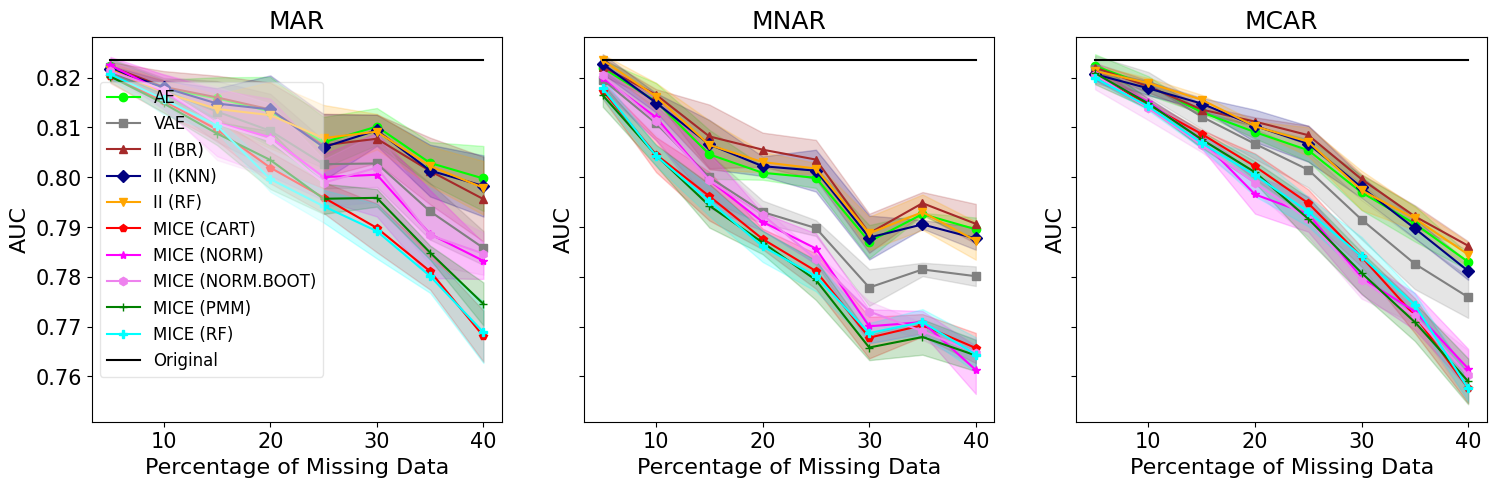

In [16]:
color_map = {
    'COMPLETE': 'blue',
    'MICE (PMM)': 'green',
    'MICE (CART)': 'red',
    'MICE (RF)': 'cyan',
    'MICE (NORM)': 'magenta',
    'MICE (NORM.BOOT)': 'violet',
    'II (RF)': 'orange',
    'II (KNN)': 'navy',
    'II (BR)': 'brown',
    'AE': 'lime',
    'VAE': 'gray',
    "Original": "black"  # Black color for the 'Original' model
}


models = ['AE', 'VAE', 'II (BR)', 'II (KNN)', 'II (RF)','MICE (CART)', 'MICE (NORM)','MICE (NORM.BOOT)','MICE (PMM)','MICE (RF)']
methods = ['AE', 'VAE', 'II (BR)', 'II (KNN)', 'II (RF)','MICE (CART)', 'MICE (NORM)','MICE (NORM.BOOT)','MICE (PMM)','MICE (RF)']+['Original']
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', '+', 'P']
model_marker_map = dict(zip(models, markers))
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i,missing_type in enumerate(missing_types):
    ax=axs[i]
    for method in methods:
        mean_auc =  AUC_mean[(AUC_mean['Method']==method)&(AUC_mean['MissingType']==missing_type)].iloc[:,2:].values.flatten()
        std_auc =  AUC_std[(AUC_std['Method']==method)&(AUC_std['MissingType']==missing_type)].iloc[:,2:].values.flatten()
        if method== 'Original':
           mean_auc = AUC_mean[(AUC_mean['Method']==method)].iloc[:,2:].values.flatten()
           ax.plot(range(5, 45, 5), mean_auc, '-', color='black', label=method)  # Straight black line for 'Original'
        else:
            x = range(5, 45, 5)
            ax.plot(x, mean_auc, marker=model_marker_map[method], color=color_map[method], label=method)
            ax.fill_between(x, mean_auc - std_auc, mean_auc + std_auc, color=color_map[method], alpha=0.2)
    if i == 0:
       legend = ax.legend(loc='center left', fontsize=12)
       legend.get_frame().set_alpha(0.5)

    ax.set_title(f"{missing_type}", fontsize=18)
    ax.set_xlabel('Percentage of Missing Data', fontsize=16)
    ax.set_ylabel('AUC', fontsize=16)

